In [1]:
import torch
from torch.utils.data import DataLoader
from datasets import load_dataset
from transformers import AutoTokenizer

# Load the TinyStories dataset
dataset = load_dataset("roneneldan/TinyStories")
tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-uncased")  # or any suitable tokenizer
if tokenizer.pad_token is None:
    tokenizer.add_special_tokens({'pad_token': '[PAD]'})
# Preprocess the dataset
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=64)

tokenized_datasets = dataset.map(tokenize_function, batched=True)
tokenized_datasets = tokenized_datasets.remove_columns(["text"])  # Remove original text, keep only tokens
tokenized_datasets.set_format("torch")  # Set format to PyTorch tensors

vocab_size=tokenizer.vocab_size+1
device="cuda" if torch.cuda.is_available() else "cpu"

/home/user/anaconda3/lib/python3.11/site-packages/huggingface_hub/repocard.py:105: UserWarning: Repo card metadata block was not found. Setting CardData to empty.
  warnings.warn("Repo card metadata block was not found. Setting CardData to empty.")


In [2]:
import math
from continous_diffusion import Diffusion,DiffusionTransformer,Loss,Embedder,CauchySchedule

embed_dim=128
qkv_dim=1024
num_heads=8
cond_dim=16
n_blocks=8

dit=DiffusionTransformer(embed_dim,qkv_dim,num_heads,cond_dim,n_blocks)
embedder=Embedder(vocab_size,embed_dim)
schedule=CauchySchedule(0.01,200,0,0.3,math.log(vocab_size),0)
loss=Loss(embedder,schedule)
model=Diffusion(dit,loss).to(device)

print(model.n_parameters)

4461088


In [3]:
# DataLoader
train_loader = DataLoader(tokenized_datasets["train"], batch_size=256, shuffle=True)
optimizer = torch.optim.AdamW(model.parameters(),lr=1e-4)

# Learning-rate scheduling
from torch.optim.lr_scheduler import SequentialLR, ConstantLR, LinearLR, ExponentialLR
warmup=LinearLR(optimizer,1e-3,1,5)
decay=ExponentialLR(optimizer,gamma=0.9)
scheduler=SequentialLR(optimizer,[warmup,decay],milestones=[6])

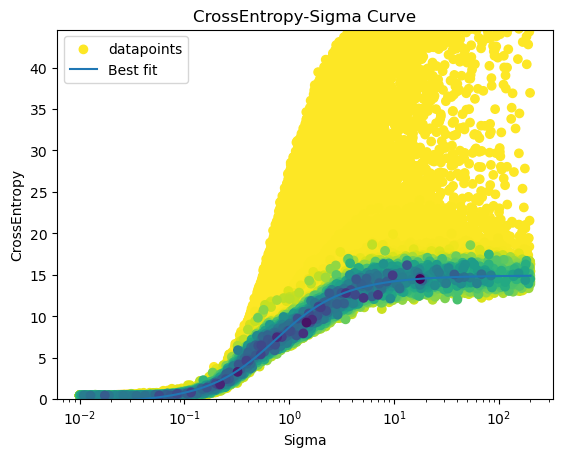

lr: [6.961986091308869e-08]
Step: 3750,  Loss: 7.617069244384766
Step: 3751,  Loss: 6.551258087158203
Step: 3752,  Loss: 7.235800266265869
Step: 3753,  Loss: 6.808211803436279
Step: 3754,  Loss: 7.5809221267700195
Step: 3755,  Loss: 6.9944353103637695
Step: 3756,  Loss: 7.197019577026367
Step: 3757,  Loss: 7.270014762878418
Step: 3758,  Loss: 7.358747482299805
Step: 3759,  Loss: 7.321724891662598
Step: 3760,  Loss: 7.09030818939209
Step: 3761,  Loss: 6.925884246826172
Step: 3762,  Loss: 7.291011810302734
Step: 3763,  Loss: 7.215003490447998
Step: 3764,  Loss: 7.234467506408691
Step: 3765,  Loss: 7.255465030670166
Step: 3766,  Loss: 6.9690423011779785
Step: 3767,  Loss: 6.901271820068359
Step: 3768,  Loss: 7.293063640594482
Step: 3769,  Loss: 7.492705345153809
Step: 3770,  Loss: 7.099819660186768
Step: 3771,  Loss: 6.735073089599609
Step: 3772,  Loss: 7.199763298034668
Step: 3773,  Loss: 7.560895919799805
Step: 3774,  Loss: 7.149572849273682
Step: 3775,  Loss: 7.434430122375488
Step: 37

In [4]:
schedule_update_frequency=2000

from IPython.display import clear_output
# Training loop
model.train()
for epoch in range(1):  # Define num_epochs
    for i,batch in enumerate(train_loader):

        optimizer.zero_grad()  
        tokens = batch['input_ids'].to(device)
        x,sigma,attn_mask=model.make_sample(tokens)
        prediction=model(x,sigma,attn_mask)
        # Forward pass
        loss = model.loss(tokens,prediction,sigma)

        loss.backward()

        optimizer.step()
        # Log, print, or save as needed

        if i%schedule_update_frequency==0 and i!=0:
            schedule.update_optimal_parameters()

        if i%50==0 and i!=0:
            scheduler.step()
            clear_output(wait=True) 
            schedule.plot_entropy_time_curve()
            print(f"lr: {scheduler.get_last_lr()}")

        print(f"Step: {i},  Loss: {loss.item()}")


In [ ]:
model.generate(1,64,1000,device=device)

In [ ]:
model.schedule.optimal_parameters

Parameter containing:
tensor([ 0.1884,  0.1834,  3.7468, -1.0581])